# Forecasting COVID-19 in Kenya (Deaths)

Alex Bengo Libosso.
KCA University.
Email: xxxxxx@gmail.com.
Admission Number: xxxxx.

In [6]:
# Step 1: Importing the libraries we need
import warnings
import itertools
import pandas as pd
from pandas import read_csv
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns

# PreProcessing

Here I will clean up the data. I first drop unwanted columns from the original csv file, then I transpose the data and remove all other countries except Kenya. Finally I define the index column and check for null values

In [7]:
# Step 2: PreProcessing time_series_covid19_deaths_global Data
covid_df = pd.read_csv ("C:/2020python/time_series_covid19_deaths_global.csv")

# Show the raw data(limit to first 5 records)
covid_df.head(5)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20,5/11/20,5/12/20,5/13/20,5/14/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,95,104,106,109,115,120,122,127,132,136
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,31,31,31,31,31,31,31,31,31,31
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,470,476,483,488,494,502,507,515,522,529
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,46,46,47,47,48,48,48,48,49,49
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,2,2,2,2,2,2,2,2,2,2


In [8]:
# Drop columns we do not require
covid_df.drop('Province/State', axis=1, inplace=True)
covid_df.drop('Lat', axis=1, inplace=True)
covid_df.drop('Long', axis=1, inplace=True)

# Transpose (convert rows to columns) and remove index
covid_df = covid_df.set_index('Country/Region').transpose()
covid_df = covid_df.reset_index()
covid_df = covid_df.drop(covid_df.index[0])

# Drop columns we do not require after transposing
covid_df = covid_df.drop(covid_df.loc[:, 'Afghanistan' : 'Kazakhstan'].columns, axis = 1)
covid_df = covid_df.loc[:, :'Kenya']

# Rename new columns
covid_df = covid_df.rename(columns={'index' : 'Date'})
covid_df = covid_df.rename(columns={'Kenya' : 'Deaths'})

# Convert Date column to the correct format
covid_df['Date'] = pd.to_datetime(covid_df['Date'], format='%m/%d/%y')

# Set Date as the index
covid_df = covid_df.set_index('Date')

# Check which are the columns the contains NaN values in it :
covid_df.isnull().any()

Country/Region
Deaths    False
dtype: bool

In [9]:
# Show the final Output (limit to first 5 records)
covid_df.head(5)

Country/Region,Deaths
Date,
2020-01-23,0
2020-01-24,0
2020-01-25,0
2020-01-26,0
2020-01-27,0


# Data Analysis

Here I explore the time series data using some visualizations.
Some distinguishable patterns appear when we plot the data. 

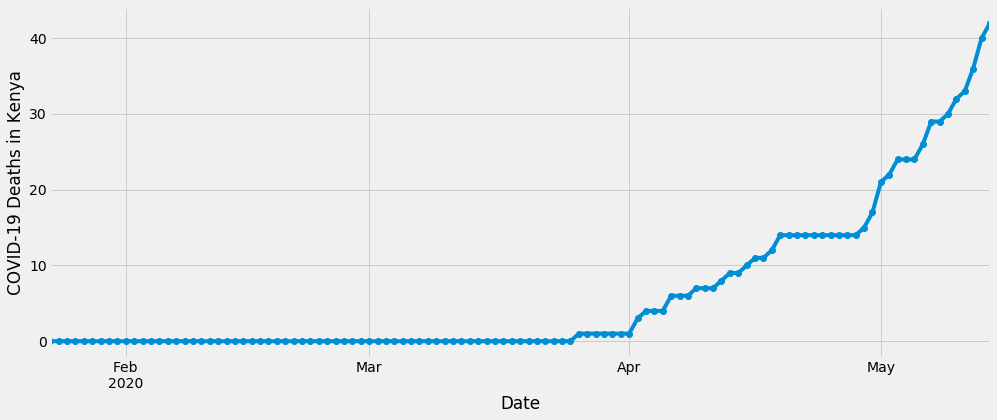

In [10]:
#Step 3: Visualize the time series data
ax = covid_df.loc['2020-01-23':'2020-05-14', 'Deaths'].plot(marker='o', linestyle='-', figsize=(15, 6))
ax.set_ylabel('COVID-19 Deaths in Kenya');

In [11]:
# Resampling (involves an aggregation operation)
df_weekly_mean = covid_df.resample(rule='W').mean()

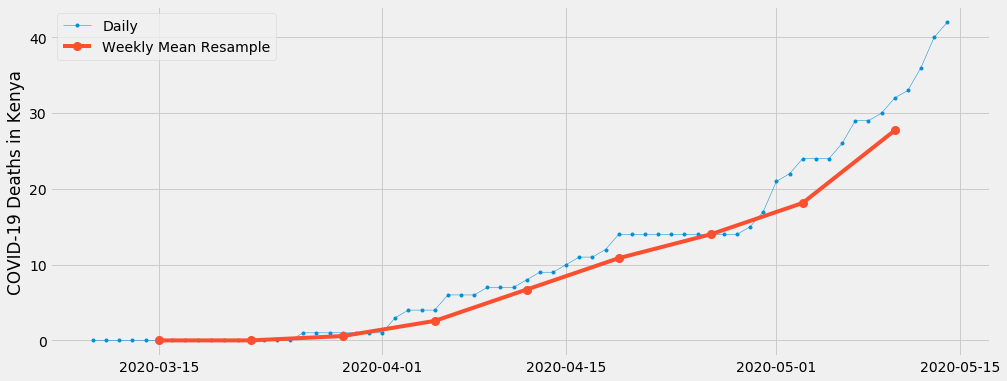

In [12]:
# Start and end of the date range to extract
start, end = '2020-03-10', '2020-05-14'

# Plot daily and weekly resampled time series together
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(covid_df.loc[start:end, 'Deaths'],
marker = '.', linestyle='-', linewidth=0.5, label='Daily')
ax.plot(df_weekly_mean.loc[start:end, 'Deaths'],
marker = 'o', markersize=8, linestyle='-', label='Weekly Mean Resample')
ax.set_ylabel('COVID-19 Deaths in Kenya')
ax.legend();

# Model Design

I choose the one of the most commonly used method for time-series forecasting, known as ARIMA, which stands for Autoregressive Integrated Moving Average. ARIMA models are denoted with the notation ARIMA(p, d, q). These three parameters account for seasonality, trend, and noise in data.
For each combination of parameters, I will fit a new seasonal ARIMA model with the SARIMAX() function from the statsmodels module and assess its overall quality. Once I have explored the entire landscape of parameters, my optimal set of parameters will be the one that yields the best performance for my criteria of interest. 

In [13]:
# Step 4 (a): Parameter Selection for the ARIMA Time Series Model

# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [14]:
# Step 4 (b): Automate the process of training and evaluating the model

# After fitting each SARIMAX()model, this code prints out its respective AIC score 
#(we are interested in finding the model that yields the lowest AIC value.)

warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(covid_df,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:876.8841335515615
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:744.4936327018045
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:655.5964001275635
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:564.0718956885603
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:482.02191611332495
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:474.8763780238292
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:499.485964707761
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:450.77327890929325
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:729.5672818116325
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:666.2215682409359
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:528.3524208018557
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:452.61912845733343
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:381.1461004870468
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:370.78386365771485
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:408.600696347056
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:359.9733763234883
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:298.55222287277036
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:261.71116320644603
ARIMA(

In [15]:
# Step 4 (c): Fitting an ARIMA Time Series Model
# plug the optimal parameter values into a new SARIMAX model:
mod = sm.tsa.statespace.SARIMAX(covid_df,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

# Print the table of coefficients
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9989      0.055     18.162      0.000       0.891       1.107
ma.L1         -0.8185      0.104     -7.869      0.000      -1.022      -0.615
ar.S.L12      -0.5644      0.170     -3.323      0.001      -0.897      -0.232
ma.S.L12      -0.0555      0.228     -0.244      0.808      -0.502       0.391
sigma2         0.4583      0.049      9.432      0.000       0.363       0.554


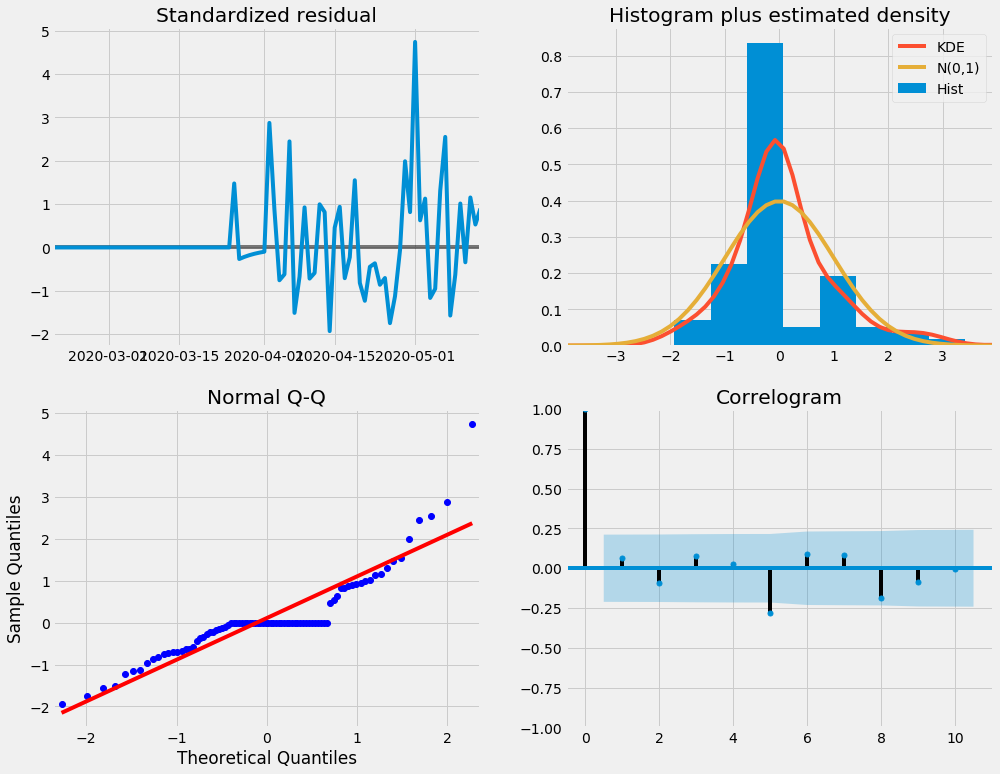

In [16]:
#Step 4 (d): run model diagnostics to ensure that none of the assumptions made by the model have been violated.
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [17]:
# Step 5: Validating Forecasts
# Compare predicted values to real values of the time series to understand the accuracy of our forecasts.
pred = results.get_prediction(start=pd.to_datetime('2020-05-01'), dynamic=False)
pred_ci = pred.conf_int()

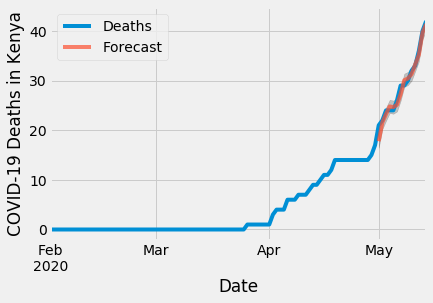

In [18]:
# Plot the real and forecasted values of the time series data to assess accuracy

ax = covid_df['2020-02-01':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('COVID-19 Deaths in Kenya')
plt.legend()

plt.show()

In [19]:
# Step 6: Quantify the accuracy of the forecasts. 
# Use the MSE (Mean Squared Error), which summarizes the average error of the forecasts. 
y_forecasted = pred.predicted_mean
y_truth = covid_df['2020-05-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 2020-05-01 00:00:00   NaN
2020-05-02 00:00:00   NaN
2020-05-03 00:00:00   NaN
2020-05-04 00:00:00   NaN
2020-05-05 00:00:00   NaN
2020-05-06 00:00:00   NaN
2020-05-07 00:00:00   NaN
2020-05-08 00:00:00   NaN
2020-05-09 00:00:00   NaN
2020-05-10 00:00:00   NaN
2020-05-11 00:00:00   NaN
2020-05-12 00:00:00   NaN
2020-05-13 00:00:00   NaN
2020-05-14 00:00:00   NaN
Deaths                NaN
dtype: float64


In [20]:
# Plot the observed and forecasted values of the time series using dynamic forecasts.
pred_dynamic = results.get_prediction(start=pd.to_datetime('2020-05-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

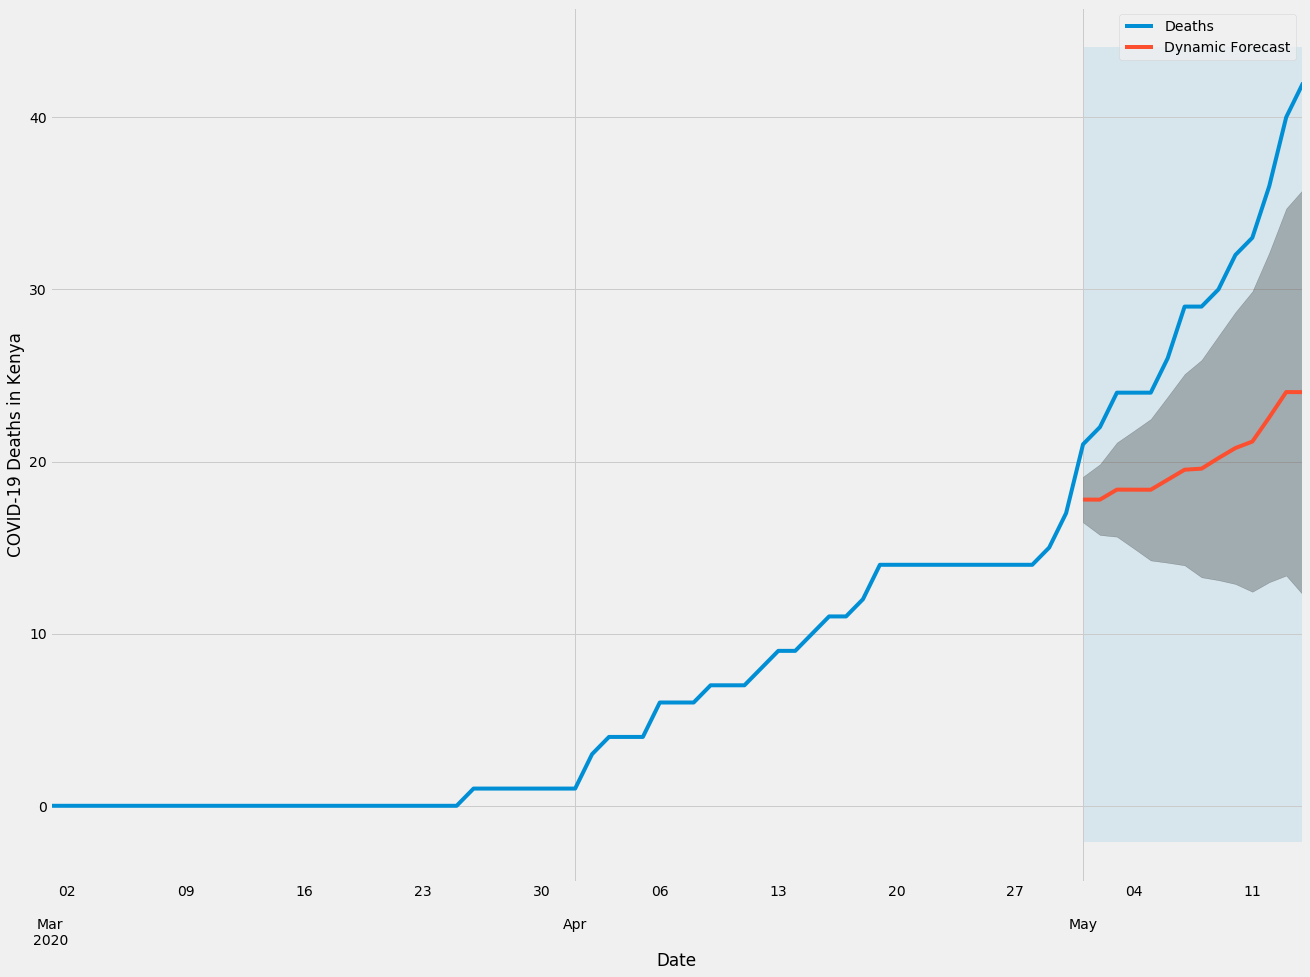

In [21]:
# Ensure we are well within the confidence intervals of our forecast.
ax = covid_df['2020-03-01':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2020-05-01'), covid_df.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('COVID-19 Deaths in Kenya')

plt.legend()
plt.show()

In [22]:
# Extract the predicted and true values of our time series
y_forecasted = pred_dynamic.predicted_mean
y_truth = covid_df['2020-05-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 2020-05-01 00:00:00   NaN
2020-05-02 00:00:00   NaN
2020-05-03 00:00:00   NaN
2020-05-04 00:00:00   NaN
2020-05-05 00:00:00   NaN
2020-05-06 00:00:00   NaN
2020-05-07 00:00:00   NaN
2020-05-08 00:00:00   NaN
2020-05-09 00:00:00   NaN
2020-05-10 00:00:00   NaN
2020-05-11 00:00:00   NaN
2020-05-12 00:00:00   NaN
2020-05-13 00:00:00   NaN
2020-05-14 00:00:00   NaN
Deaths                NaN
dtype: float64


In [23]:
# Step 7: Forecast future values
# Get forecast 100 steps ahead in future
pred_uc = results.get_forecast(steps=100)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

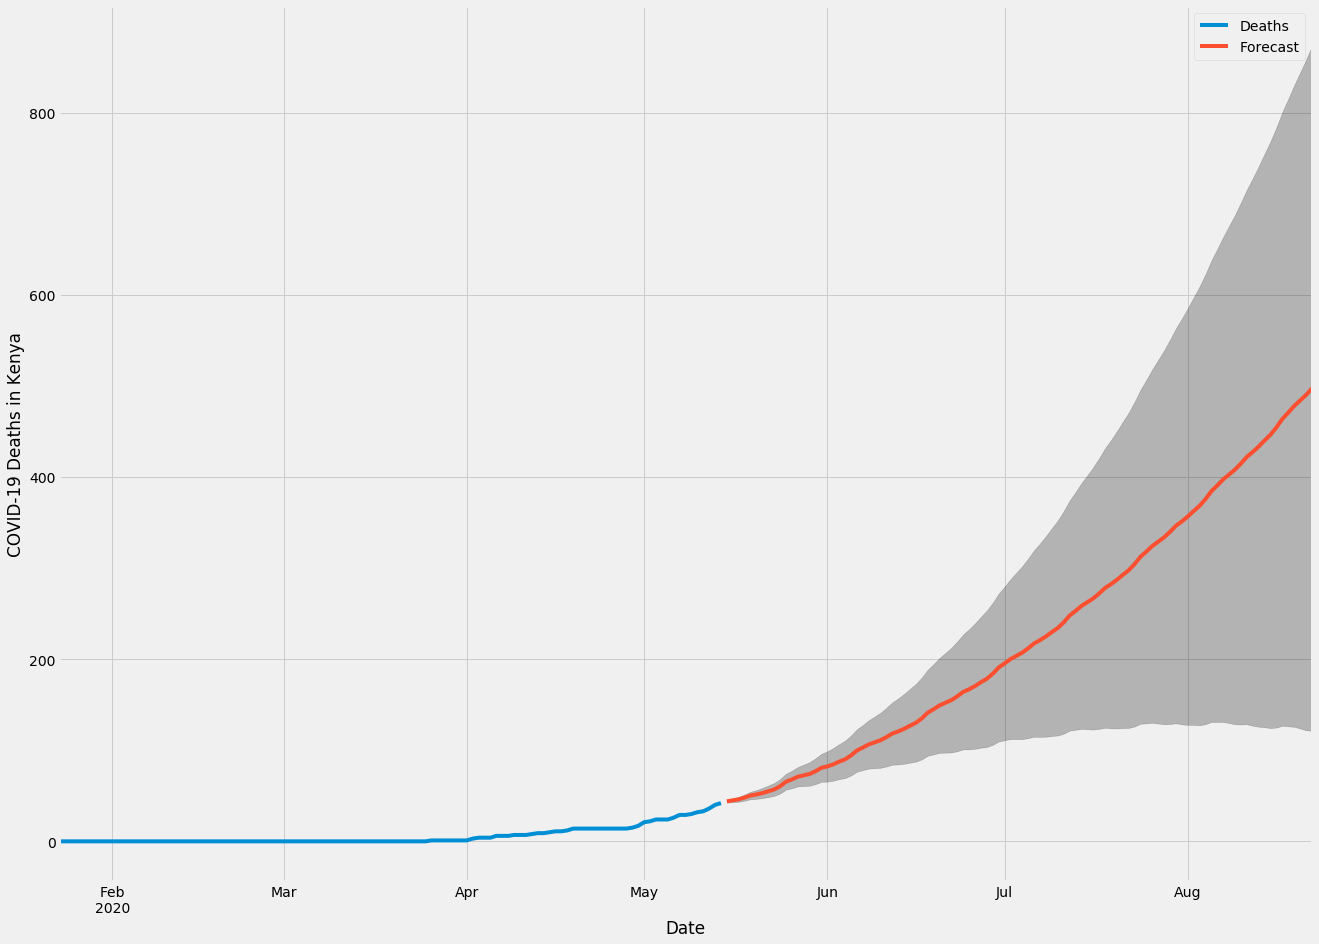

In [24]:
ax = covid_df.plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('COVID-19 Deaths in Kenya')

plt.legend()
plt.show()

In [390]:
# END